<a href="https://colab.research.google.com/github/tonyvu1289/Project3-nmkhdl/blob/main/nmkhdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import vncorenlp
from vncorenlp import VnCoreNLP
import re
import seaborn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


# Đọc dataset và những dữ liệu cần thiết (stopword, thư viện java)

In [2]:
data=pd.read_csv("vn_news_223_tdlfr.csv")
data.head()
#stopword
f = open('stopwords.txt', 'r', encoding='UTF-8')
stopwords = f.read().split('\n')
#java library
annotator = VnCoreNLP("VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')

# Tiền xử lý dữ liệu (Data preprocessing)
## 1. Xử lý noise
Các noise trong văn bản bao gồm các link, dấu xuống dòng, các kí tự đặc biệt, viết hoa sẽ được xử lý

In [3]:
data["text"] = data["text"].str.lower()
data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
data['text'] = data['text'].apply(lambda x: x.replace('\n',' '))
data['text'] = data['text'].apply(lambda x: re.sub('[^aàảãáạăằẳẵắặâầẩẫấậ b c dđeèẻẽéẹêềểễếệ f g hiìỉĩíịjklmnoòỏõóọôồổỗốộơờởỡớợpqrstu ùủũúụưừửữứựvwxyỳỷỹýỵz +[0-9]+', '', x))
data.iloc[0,0]

'thủ tướng abe cúi đầu xin lỗi vì hành động phi thể thao của tuyển nhật theo sankei sports sáng nay thủ tướng nhật bản shinzo abe công khai gửi lời xin lỗi tới nhật hoàng và toàn bộ người dân vì tinh thần thi đấu phi thể thao của đội tuyển nhật tại world cup 2018  tối qua sau lượt trận cuối vòng bảng world cup 2018 nhật bản có cùng chỉ số phụ như senegal đội bị loại sau khi thua colombia nhưng nhật bản vào vòng sau nhờ chỉ số fairplay vì nhận ít thẻ phạt hơn thủ tướng nhật bản shinzo abe cúi đầu xin lỗi  với tinh thần của những võ sĩ đạo samurai nhưng đội tuyển nhật bản đã có những hành động thiếu tinh thần thượng võ trong thi đấu tại world cup để lại nhiều chỉ trích và bất bình cho toàn dân làm mất hình ảnh kiên cường của người dân nhật bản trên đấu trường quốc tế là người đứng đầu tôi xin thành thật nhận trách nhiệm và gửi lời xin lỗi sâu sắc tới nhân dân ông abe cúi đầu nhận trách nhiệm về mình người nhật bản nổi tiếng về tinh thần trách nhiệm và chất võ sĩ đạo đó là lý do đội tuyển

In [4]:
def reduce_dim(x):
    return x[0]
#data['text']=data['text'].apply(reduce_dim)

In [5]:
def TokenNize(s):
    return s.apply(annotator.tokenize).apply(reduce_dim)
TokenNize(data['text'])

0      [thủ_tướng, abe, cúi, đầu, xin_lỗi, vì, hành_đ...
1      [thủ_tướng, nhật, cúi, đầu, xin_lỗi, vì, tinh_...
2      [choáng, cơ_trưởng, đeo, khăn_quàng, quẩy, ban...
3      [chưa, bao_giờ, nhạc, kpop, lại, dễ, hát, đến,...
4      [đại_học, hutech, sẽ, áp_dụng, cải_cách, tiếq,...
                             ...                        
218    [siêu, máy_bay, a350, sẽ, chở, cđv, việt_nam, ...
219    [thưởng, 20000, usd, cho, đội_tuyển, cờ_vua, v...
220    [trường_sơn, giành, hcv, tại, giải, cờ_vua, đồ...
221    [chuyện, về, chàng, sinh_viên, luật, kiện_tướn...
222    [tiền_đạo, malaysia, tôi, đã, có, cách, vượt, ...
Name: text, Length: 223, dtype: object

In [6]:
def remove_stopword(list_word):
    clean_list = []
    for i in range(len(list_word)):
        temp=""
        temp1=""
        if i > 0 and i < (len(list_word)-1):
            temp = str(list_word[i]) + " " + str(list_word[i+1])
            temp1 = str(list_word[i-1]) + " " + str(list_word[i])
        if list_word[i] not in stopwords and temp not in stopwords and temp1 not in stopwords:
            clean_list.append(list_word[i])
    return clean_list
#data['text'] = data['text'].apply(lambda x: remove_stopword(x))

In [7]:
def Preprocess(s):
    return TokenNize(s).apply(remove_stopword)

In [8]:
data['clean_text'] = Preprocess(data['text'])

# Xây dựng mô hình

Bọn em sẽ dùng phương thức CountVectorizer để vector hóa văn bản. Vì vậy, bọn em sẽ gộp token sau khi được làm sạch lại thành 1 văn bản để có thể sử dụng CountVectorizer().

In [9]:
data['joined_clean_text'] = data['clean_text'].apply(lambda x:" ".join(x))

Vì đây là mô hình dự đoán dựa trên text nên bọn em sẽ chỉ xét cột `'joined_clean_text'` tức cột text sau khi qua nhiều bước làm sạch và xử lý (bỏ qua cột `domain`) làm tập X và cột `'label'` làm tập y.  
Bọn em sẽ chia tập train và validation ra theo tỉ lệ 7/3.

In [41]:
X_train, X_val,y_train,y_val = train_test_split(data['joined_clean_text'],data['label'],random_state=212,test_size=0.3)

Vì có rất nhiều mô hình nên bọn em sẽ thử tất cả những mô hình mà bọn em biết để tìm ra mô hình tối ưu nhất.  

Ba mô hình thử nghiệm là : LogisticRegression, RandomForestClassifier, SVC.

In [42]:
models = [LogisticRegression(),
sklearn.ensemble.RandomForestClassifier(),
#sklearn.naive_bayes.GaussianNB()
sklearn.svm.SVC()
]
acc_max = 0
accs = []
cm =[]
for model in models:
    full_pipeline = make_pipeline(
    CountVectorizer(),
    model
    )
    full_pipeline.fit(X_train,y_train)
    y_pred = full_pipeline.predict(X_val)
    accs.append(accuracy_score(y_val,y_pred)*100)
    cm.append(confusion_matrix(y_val,y_pred))


Mô hình có độ chính xác cao nhất cùng với độ chính xác của mô hình đó là :

So sánh độ chính xác giữa các mô hình với nhau, ta thấy không có chênh lệch quá lớn

                              val
model                            
LogisticRegression      92.537313
RandomForestClassifier  89.552239
SVC                     85.074627


<AxesSubplot:ylabel='model'>

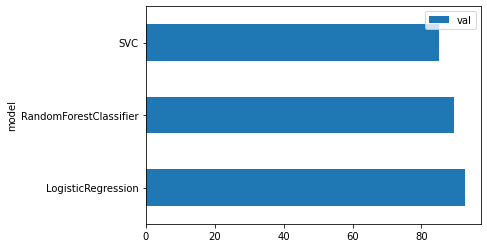

In [43]:
model_name = [type(x).__name__ for x in models]
plot_df = pd.DataFrame({'model':model_name,'val':accs}).set_index('model')
print(plot_df)
plot_df.plot.barh()

Để tối ưu, ta sẽ chọn mô hình có độ chính xác cao nhất cho phần deploy.  

Sau đây là ma trận lỗi của mô hình (tính theo tỉ lệ phần trăm). Ta thấy lỗi loại 2 (tức tin giả mà dự đoán là tin thật) chiếm tương đối ít, chấp nhận được.

<AxesSubplot:>

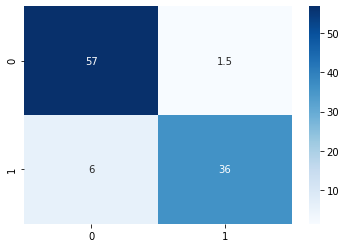

In [44]:
seaborn.heatmap(cm[accs.index(max(accs))]/len(y_val)*100,annot=True,cmap='Blues')

Mô hình với độ chính xác cao nhất là :

In [45]:
best_model = models[accs.index(max(accs))]
best_model, max(accs)

(LogisticRegression(), 92.53731343283582)

# Pipeline cho việc deploy mô hình

Pipiline xây dựng dựa vào mô hình tốt nhất là : (sẽ được dùng cho phần deploy mô hình)

In [50]:
full_pipeline = make_pipeline(
    CountVectorizer(),
    best_model
    )
full_pipeline.fit(data['joined_clean_text'],data['label'])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression())])

Demo pipeline cho bộ phận deploy mô hình

In [52]:
# muốn dự đoán văn bản gì thì dùng cú pháp như sau :
text_test = "Thủ tướng Abe cúi đầu xin lỗi vì hành động phi thể thao của tuyển Nhật Theo Sankei Sports, sáng nay Thủ tướng Nhật Bản Shinzo Abe công khai gửi lời xin lỗi tới Nhật hoàng và toàn bộ người dân vì tinh thần thi đấu phi thể thao của đội tuyển Nhật tại World Cup 2018.Tối qua, sau lượt trận cuối vòng bảng World Cup 2018, Nhật Bản có cùng chỉ số phụ như Senegal, đội bị loại sau khi thua Colombia. Nhưng Nhật Bản vào vòng sau nhờ chỉ số fair-play vì nhận ít thẻ phạt hơn. Thủ tướng Nhật Bản Shinzo Abe cúi đầu xin lỗi.“Với tinh thần của những võ sĩ đạo Samurai, nhưng đội tuyển Nhật Bản đã có những hành động thiếu tinh thần thượng võ trong thi đấu tại World Cup, để lại nhiều chỉ trích và bất bình cho toàn dân, làm mất hình ảnh kiên cường của người dân Nhật Bản trên đấu trường quốc tế. Là người đứng đầu, tôi xin thành thật nhận trách nhiệm và gửi lời xin lỗi sâu sắc tới nhân dân.”, ông Abe cúi đầu nhận trách nhiệm về mình. Người Nhật Bản nổi tiếng về tinh thần, trách nhiệm và chất võ sĩ đạo. Đó là lý do đội tuyển áo xanh được mệnh danh “Samurai xanh”. Tuy nhiên, Nhật Bản sau đó nhận chỉ trích dữ dội của người hâm mộ bóng đá vì lối chơi bóng tiêu cực, cố tình câu giờ để dành tấm vé đi tiếp. Cụ thể, những phút cuối trận cuối vòng bảng gặp Ba Lan, do biết ở trận cùng giờ, Colombia cũng đang thắng Senegal với tỷ số 1-0 nên dù có đang bị dẫn trước với tỉ số tương tự, các cầu thủ Nhật Bản cũng không hề muốn gỡ hòa. Các cầu thủ Nhật vui vẻ sau trận thua Ba Lan 0-1, có vé vào vòng 16 đội. Tại World Cup 2018, FIFA sẽ tính điểm fair play, theo quy định 1 thẻ vàng -1 điểm; 2 thẻ vàng thành thẻ đỏ -3 điểm; thẻ đỏ trực tiếp -4 điểm. Nhật có 4 thẻ vàng còn Senegal có đến 6.Chính vì sợ lãnh thêm thẻ vàng nên Nhật đã giết chết trận đấu trong những phút cuối. Họ liên tục chuyền bóng qua lại ở phần sân nhà. Thậm chí trong khoảng 5 phút cuối, cầu thủ Nhật Bản còn không đưa bóng sang phần sân đối phương, bất chấp sự la ó, huýt sáo của các CĐV trên sân. Điều này khiến thầy trò HLV Akira Nishino bị dư luận chỉ trích.Với kết quả trên, Nhật Bản và Colombia là hai đội đi tiếp của bảng H. Ở vòng loại trực tiếp, Nhật Bản sẽ phải đối đầu với đối thủ cực mạnh là ĐT Bỉ. Trong khi đó, đội cùng đi tiếp với Nhật là Colombia sẽ gặp ĐT Anh."
full_pipeline.predict([text_test]) #truyền vào predict phải là một list/series/array
#dáp án cũng sẽ là 1 array

array([1])